## Natural Computing project
by Loes van Bemmel, Jurriaan ten Brinke and Merel Witsenboer

In [55]:
from __future__ import division
import os
from PIL import Image
import numpy as np
from scipy.misc import imsave
%matplotlib inline
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
#import time
from IPython import display
from random import randint
from sklearn.mixture import GaussianMixture
from scipy.optimize import fsolve
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score

In [56]:
#parameters
threshold = 75 #for binary images

xlbl = 'Threshold label' #for the confusion matrix 

#patch sizes
Nx = 250
Ny = 250

In [57]:
imageFiles=[]
imageArrays=[]
for imgfile in os.listdir('dataset'):
    if imgfile.endswith('.png'):
        imageFiles.append(imgfile)
for imgfile in imageFiles:
    image=Image.open('dataset/'+imgfile).convert("L")
    imageArrays.append(np.array(image))

def binaryThresholding(image, threshold): #index in the imageArrays-list, threshold value between 0-255
    binary = image.copy()
    for i in range(len(image)):
        for j in range(len(image[0])):
            if image[i][j] > threshold:
                binary[i][j] = 255
            else:
                binary[i][j] = 0
    return binary

def saveArrayImage(name,arrayImage):
    if not(os.path.isdir("saved")):
        os.mkdir("saved")
        print("saved-directory created.")
    imsave('saved/'+name+'.png', arrayImage)
    
image = imageArrays[1] #dit is opal_540.png
label = binaryThresholding(image, threshold)
annot = Image.open('annotated/opal_540_annotated.png')
annot = (255 - np.array(annot))[:,:,0]


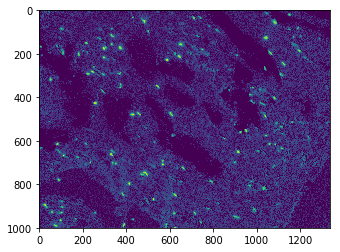

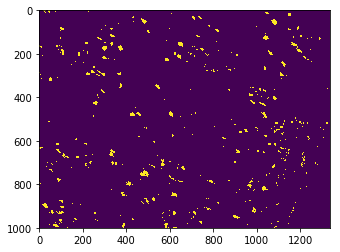

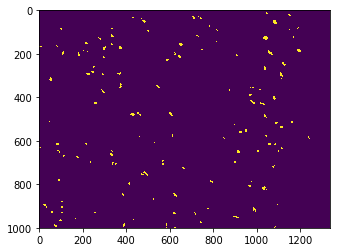

In [58]:
#print them!
plt.imshow(image)
plt.show()
plt.imshow(label)
plt.show()
plt.imshow(annot)
plt.show()

In [59]:
class PatchExtractor2:
    #returns the patch, the corresponding thresholded patch and the annotated patch
    
    def __init__(self, patch_size):
        self.patch_size = patch_size 
    
    def get_patch(self, image, thresholded, annotated):
        ''' 
        Get a patch of patch_size from input image, along with corresponding label map.
        This function works with image size >= patch_size, and pick random location of the patch inside the image.
        (Possibly) return a flipped version of the image and corresponding label.

        image: a numpy array representing the input image
        label: a numpy array representing the thresholded image of the input image
        annotated: a numpy array representing the annotated image 
        '''
        
        # pick a random location
        dims = image.shape        
        r = randint(0, dims[0]-self.patch_size[0])
        c = randint(0, dims[1]-self.patch_size[1])
        
        patch = image[r:r+self.patch_size[0], c:c+self.patch_size[1]]
        target = thresholded[r:r+self.patch_size[0], c:c+self.patch_size[1]].reshape(self.patch_size[0], self.patch_size[1])
        annot = annotated[r:r+self.patch_size[0], c:c+self.patch_size[1]].reshape(self.patch_size[0], self.patch_size[1])

        patch_out = patch #/ 255. # normalize image intensity to range [0., 1.]
        target_out = target
        annot_out = annot
            
        return patch_out, target_out, annot_out

In [60]:
#from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Annotated label',
           xlabel=xlbl)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return cm

In [61]:
#Return the difference between the probability that the pixelvalue belongs to predclass and the probability that it belongs to the other class.
def gaussianPredict(pixelvalue,mu1=0,mu2=255,sig1=60,sig2=120):
    g1 = gaussian(pixelvalue,mu1,sig1)
    g2 = gaussian(pixelvalue,mu2,sig2)
    return g1-g2

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

In [62]:
class Ising():
    ''' Simulating the Ising model '''    
    ## monte carlo moves
    def mcmove(self, config, Nx, Ny, beta, image):
        ''' This is to execute the monte carlo moves using 
        Metropolis algorithm such that detailed
        balance condition is satisified'''
        for i in range(Nx):
            for j in range(Ny):            
                    
                    a = np.random.randint(0, Nx)
                    b = np.random.randint(0, Ny)
                    s =  config[a, b]
                    nb = config[(a+1)%Nx,b] + config[a,(b+1)%Ny] + config[(a-1)%Nx,b] + config[a,(b-1)%Ny] 
                    nb += config[(a+1)%Nx,(b+1)%Ny] + config[(a+1)%Nx,(b+1)%Ny] + config[(a-1)%Nx,(b-1)%Ny] + config[(a-1)%Nx,(b-1)%Ny ]#use 8 neighbours, or even neighbours of neighbours, 2nd order neighbours

        
                    pixv = image[a,b]
                    g = gaussianPredict(pixv,mu1=mu1,mu2=mu2,sig1=sig1,sig2=sig2)
                    # g is negative if pixv is high
                    # g is small around the threshold
                    # g is high if pixv is low 
                    
                    cost = s*nb*J - J2*g*s 
                    
                    if cost < 0:
                        s *= -1
                    elif rand() < np.exp(-cost*beta): #beta is temperature
                        s *= -1
                    
                    config[a, b] = s
                    
        return config
    
    def simulate(self, image):   
        ''' This module simulates the Ising model'''
        
        config = 2*np.random.randint(2, size=(Nx,Ny))-1
        self.configPlot(config, 0, Nx, Ny); #,1
        
        actu = (np.ravel(patches[2])/255)
        actu2 = (np.ravel(patches[1])/255)
        dices = []
        dices2 = []
        
        for i in range(msrmnt):
            result = self.mcmove(config, Nx, Ny, 1.0/temp, image)   
            pred = np.ravel(result)
            pred[pred<0] = 0
            cm = confusion_matrix(actu, pred)
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

            dice = (2*cm[1][1]) / (cm[1][1] + cm[0][1] + cm[1][1] + cm[1][0])
            dices.append(dice)
            
            cm2 = confusion_matrix(actu2, pred)
            cm2 = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]
            
            dice2 = (2*cm2[1][1]) / (cm2[1][1] + cm2[0][1] + cm2[1][1] + cm2[1][0])
            dices2.append(dice2)
            
            if i%2==0:
                self.configPlot(config, i+1, Nx, Ny);

        return [result, dices, dices2]
                    
    def configPlot(self, config, i, Nx, Ny): #,_n
        ''' This modules plts the configuration once passed to it along with time etc '''
        X, Y = np.meshgrid(range(Nx), range(Ny))
        plt.imshow(config);
        plt.title('Time=%d'%i); plt.axis('tight')
        plt.show()
        #display.clear_output(wait=True)
        #display.display(plt.gcf())

In [63]:
rm = Ising()

In [64]:
#parameters
threshold = 75 #for binary images
J = 1/8 #neighbouring weight
J2 = 1.4 #pixel value weight
temp = 0.2 #change temperature, simulated annealing   
msrmnt = 11 #amount of iterations..

x = np.linspace(0, 255) #all values a pixel could have
mu1 = 0 #mean of first gaussian
mu2 = 255 #mean of second gaussian
sig1 = 80 #variance of first gaussian
sig2 = 150 #variance of second gaussian

label = binaryThresholding(image, threshold)

patch_generator2 = PatchExtractor2((Nx, Ny))
patches = patch_generator2.get_patch(image, label, annot)

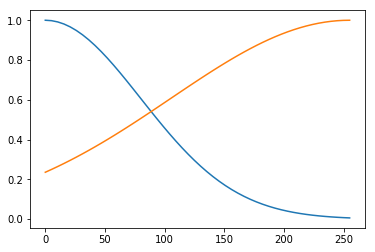

In [65]:
#plot the gaussian we use for pixel value probability
g1 = gaussian(x,mu1,sig1)
g2 = gaussian(x,mu2,sig2)

plt.plot(x, g1)
plt.plot(x, g2)
plt.show()

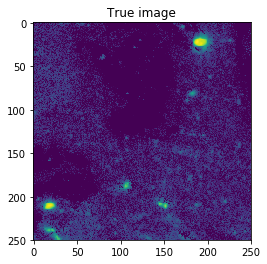

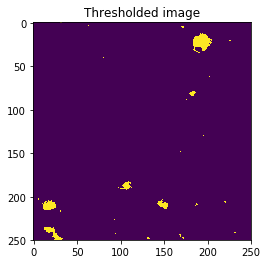

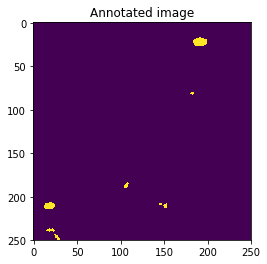

In [66]:
#true image, the thresholded label, and the annotation patches
plt.imshow(patches[0])
plt.title('True image')
plt.show()
plt.imshow(patches[1])
plt.title('Thresholded image')
plt.show()
plt.imshow(patches[2])
plt.title('Annotated image')
plt.show()

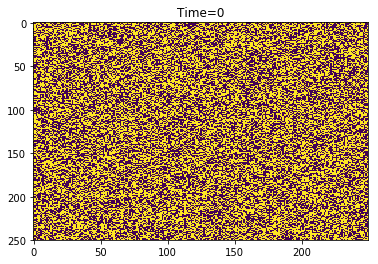

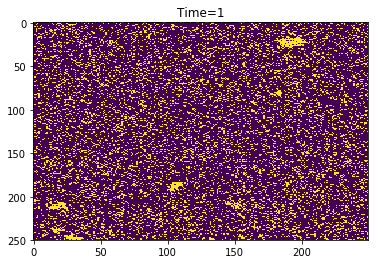

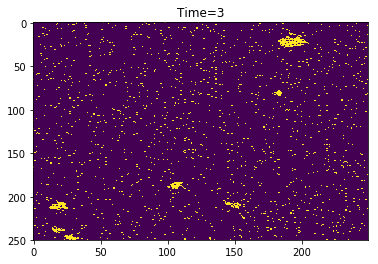

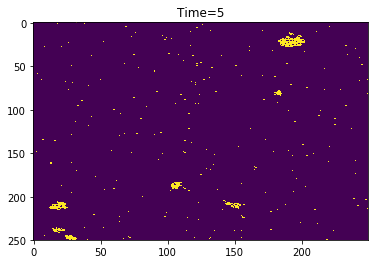

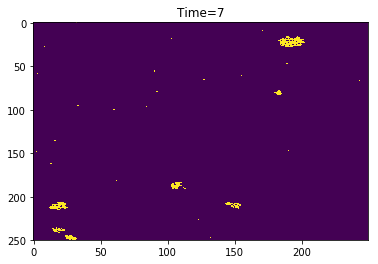

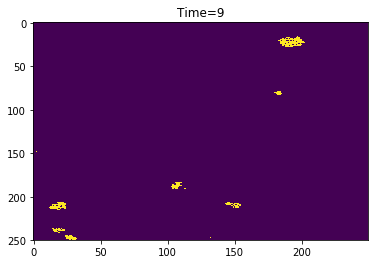

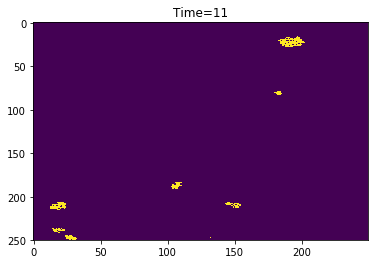

In [67]:
res = rm.simulate(patches[0])
dices = res[1]
dices2 = res[2]

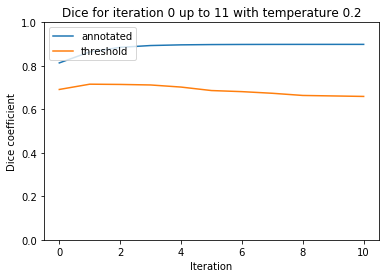

In [69]:
#plot for each generation lol
titel = "Dice for iteration 0 up to 11 with temperature 0.2"
plt.plot(range(msrmnt), dices)
plt.plot(range(msrmnt), dices2)
plt.title(titel)
plt.xlabel("Iteration")
plt.ylabel("Dice coefficient")
plt.legend(['annotated', 'threshold'], loc='upper left')
plt.ylim(0, 1)
plt.show()